In [9]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib import cm
from scipy import io
import cvxopt as cvp

In [10]:
data_lin = io.loadmat('SVM_data.mat')
data_nonlin = io.loadmat('SVM_data_nonlinear.mat')

In [23]:
x_lin = np.array(data_lin['x']).astype('float64')
y_lin = np.array(data_lin['y']).astype('float64')
y_lin = np.reshape(y_lin, (y_lin.shape[0], 1))
n1 = x_lin.shape[0]

print(y_lin.T.shape)

x_nonlin = np.array(data_nonlin['x']).astype('float64')
y_nonlin = np.array(data_nonlin['y']).astype('float64')
y_nonlin = np.reshape(y_nonlin, (y_nonlin.shape[0], 1))
n2 = x_nonlin.shape[0]

(1, 40)


In [12]:
def svm_train(x, y, kernel = 'linear', P = 2, gamma = 3, C = None):
    n = y.shape[0]
    Q = np.zeros((n, n))
    
    if kernel == 'linear':
        for i in range(n):
            for j in range(n):
                Q[i, j] = y[i] * y[j] * np.dot(x[i], x[j])
    elif kernel == 'polynomial':
        for i in range(n):
            for j in range(n):
                Q[i, j] = y[i] * y[j] * np.power(5 + np.dot(x[i], x[j]), P)
    elif kernel == 'gaussian':
        for i in range(n):
            for j in range(n):
                Q[i, j] = y[i] * y[j] * np.exp((-1 * np.square(np.linalg.norm(x[i] - x[j], ord = None)))/(2 * np.square(gamma)))
    else:
        print('Invalid kernel input!\n')
        return
    
    print((Q==Q.T).all())

    P_qp = cvp.matrix(Q)
    q_qp = cvp.matrix(np.ones((n, 1)))
    if C is None:
        G_qp = cvp.matrix(np.diag(np.ones(n) * -1))
        h_qp = cvp.matrix(np.zeros(n))
    else:
        G_qp = cvp.matrix(np.vstack((np.diag(np.ones(n) * -1), np.identity(n))))
        h_qp = cvp.matrix(np.hstack((np.zeros(n), np.ones(n) * C)))
    A_qp = cvp.matrix(y.T)
    b_qp = cvp.matrix(0.0)

    alphas = cvp.solvers.qp(P = P_qp, q = -q_qp, G = G_qp, h = h_qp, A = A_qp, b = b_qp)['x']
    alphas = np.array(alphas)
    
    support_vect_x = []
    support_vect_y = []
    alphas_nz = []
    num_vect = 0
    
    for i in range(n):
        if (alphas[i][0] > 1e-5):
            support_vect_x.append(x[i])
            support_vect_y.append(y[i])
            alphas_nz.append(alphas[i])
            num_vect += 1
    
    max_alpha_ind = alphas_nz.index(np.max(alphas_nz))
    
    support_vect_x = np.reshape(np.array(support_vect_x), (num_vect, x.shape[1]))
    support_vect_y = np.reshape(np.array(support_vect_y), (num_vect, y.shape[1]))
    alphas_nz = np.reshape(np.array(alphas_nz), (num_vect, alphas.shape[1]))

    if num_vect > 0:
        intercept = support_vect_y[0]
        to_sum = 0
        for i in range(num_vect):
            if kernel == 'linear':
                to_sum += alphas_nz[i] * support_vect_y[i] * np.dot(support_vect_x[i].T, support_vect_x[max_alpha_ind])
            elif kernel == 'polynomial':
                to_sum += alphas_nz[i] * support_vect_y[i]* np.power(5 + np.dot(support_vect_x[i].T, support_vect_x[max_alpha_ind]), P)
            elif kernel == 'gaussian':
                to_sum += alphas_nz[i] * support_vect_y[i] * np.exp((-1 * np.square(np.linalg.norm(support_vect_x[i] - support_vect_x[max_alpha_ind], ord = None)))/(2 * np.square(gamma)))
        intercept = intercept - to_sum
    
    return support_vect_x, support_vect_y, alphas_nz, intercept
 
    
    
def svm_test(x, sv_x, sv_y, alphas, intercept, kernel = 'linear', P = 2, gamma = 1):
    num_obs = x.shape[0]
    num_vect = sv_x.shape[0]
    
    y = np.zeros((num_obs, 1))
    
    for i in range(num_obs):
        to_sum = 0
        for j in range(num_vect):
            if kernel == 'linear':
                to_sum += alphas[j] * sv_y[j] * np.dot(sv_x[j].T, x[i])
            elif kernel == 'polynomial':
                to_sum += alphas[j] * sv_y[j] * np.power(5 + np.dot(sv_x[j].T, x[i]), P)
            elif kernel == 'gaussian':
                to_sum += alphas[j] * sv_y[j] * np.exp((-1 * np.square(np.linalg.norm(sv_x[j] - x[i], ord = None)))/(2 * np.square(gamma)))
            else:
                print('Invalid kernel input!\n')
                return
        
        y[i] = np.sign(to_sum + intercept)
    
    return y

In [13]:
sv_x, sv_y, alphas, intercept = svm_train(x_lin, y_lin, 'linear')

True
     pcost       dcost       gap    pres   dres
 0: -3.1176e+00 -5.1557e+00  9e+01  1e+01  2e+00
 1: -1.2428e+00 -7.5360e-01  1e+01  1e+00  2e-01
 2: -2.4063e-02 -4.7515e-01  5e-01  4e-16  1e-15
 3: -1.6470e-01 -2.3952e-01  7e-02  1e-16  6e-16
 4: -2.0198e-01 -2.3119e-01  3e-02  1e-16  4e-16
 5: -2.2569e-01 -2.2975e-01  4e-03  1e-16  3e-16
 6: -2.2907e-01 -2.2911e-01  4e-05  1e-16  4e-16
 7: -2.2910e-01 -2.2910e-01  4e-07  9e-17  4e-16
 8: -2.2910e-01 -2.2910e-01  4e-09  1e-16  4e-16
Optimal solution found.


In [14]:
print(sv_x)
print(sv_y)

[[-0.61636989  1.06270493]
 [ 0.39669013 -2.76370764]
 [ 2.33937204  0.17642596]]
[[-1.]
 [ 1.]
 [ 1.]]


In [15]:
x1 = np.linspace(np.min(x_lin[:,0]), np.max(x_lin[:,0]), 500)
scale1 = 500/(np.max(x_lin[:,0]) - np.min(x_lin[:,0]))
x2 = np.linspace(np.min(x_lin[:,1]), np.max(x_lin[:,1]), 500)
scale2 = 500/(np.max(x_lin[:,1]) - np.min(x_lin[:,1]))

y_list = np.zeros((500, 500))

print(sv_x.shape)

for i in range(500):
    for j in range(500):
        y_list[i, j] = svm_test(np.array([[x1[i], x2[j]]]), sv_x, sv_y, alphas, intercept, 'linear')

(3, 2)


Text(0.5, 1.0, 'Graph of boundary with linearly seperable data')

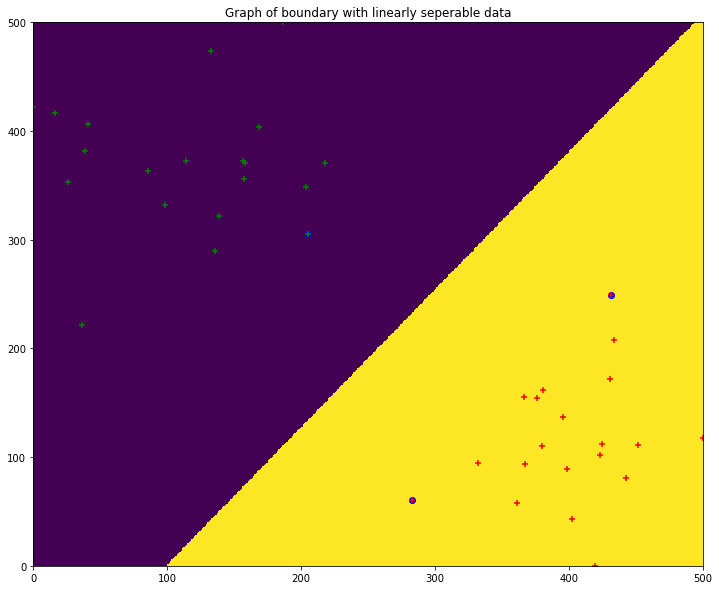

In [16]:
class1 = []
class2 = []

for i in range(y_lin.shape[0]):
    if y_lin[i] == 1:
        class1.append(x_lin[i])
    elif y_lin[i] == -1:
        class2.append(x_lin[i])

class1 = np.array(class1)
class2 = np.array(class2)

fig, ax = plt.subplots(figsize=[12,10])
ax.pcolormesh(y_list.T)
ax.scatter(scale1*(sv_x[:,0] - np.min(x_lin[:,0])), scale2*(sv_x[:,1] - np.min(x_lin[:,1])), color = 'b')
ax.scatter(scale1*(class2[:,0] - np.min(x_lin[:,0])), scale2*(class2[:,1] - np.min(x_lin[:,1])), color = 'g', marker = "+")
ax.scatter(scale1*(class1[:,0]- np.min(x_lin[:,0])), scale2*(class1[:,1] - np.min(x_lin[:,1])), color = 'r', marker = "+")
ax.set_title('Graph of boundary with linearly seperable data')

In [17]:
sv_x1, sv_y1, alphas1, intercept1 = svm_train(x_nonlin, y_nonlin, 'polynomial', P = 2, gamma = 1)

True
     pcost       dcost       gap    pres   dres
 0: -1.1128e+01 -2.2593e+01  2e+02  2e+01  2e+00
 1: -2.2234e+01 -2.4431e+01  1e+02  8e+00  1e+00
 2: -9.9779e+01 -1.0522e+02  1e+02  8e+00  1e+00
 3: -4.4755e+02 -4.2892e+02  2e+02  7e+00  1e+00
 4: -2.8529e+02 -2.3502e+02  2e+02  6e+00  8e-01
 5: -9.7070e+01 -4.9580e+01  2e+02  3e+00  4e-01
 6: -2.2982e+01 -1.5066e+01  4e+01  4e-01  5e-02
 7: -1.7679e+01 -1.3471e+01  3e+01  3e-01  4e-02
 8: -1.1177e+01 -1.0686e+01  1e+01  1e-01  1e-02
 9: -8.2952e+00 -8.6163e+00  1e+00  7e-03  1e-03
10: -8.0844e+00 -8.5034e+00  7e-01  2e-03  2e-04
11: -8.3269e+00 -8.3809e+00  7e-02  2e-04  2e-05
12: -8.3656e+00 -8.3662e+00  8e-04  2e-06  2e-07
13: -8.3661e+00 -8.3661e+00  8e-06  2e-08  2e-09
14: -8.3661e+00 -8.3661e+00  8e-08  2e-10  2e-11
Optimal solution found.


In [18]:
x11 = np.linspace(np.min(x_nonlin[:,0]), np.max(x_nonlin[:,0]), 500)
scale11 = 500/(np.max(x_nonlin[:,0]) - np.min(x_nonlin[:,0]))

x21 = np.linspace(np.min(x_nonlin[:,1]), np.max(x_nonlin[:,1]), 500)
scale21 = 500/(np.max(x_nonlin[:,1]) - np.min(x_nonlin[:,1]))


y_list1 = np.zeros((500, 500))

for i in range(500):
    for j in range(500):
        y_list1[i, j] = svm_test(np.array([[x11[i], x21[j]]]), sv_x1, sv_y1, alphas1, intercept1, 'polynomial', P = 2, gamma = 1)

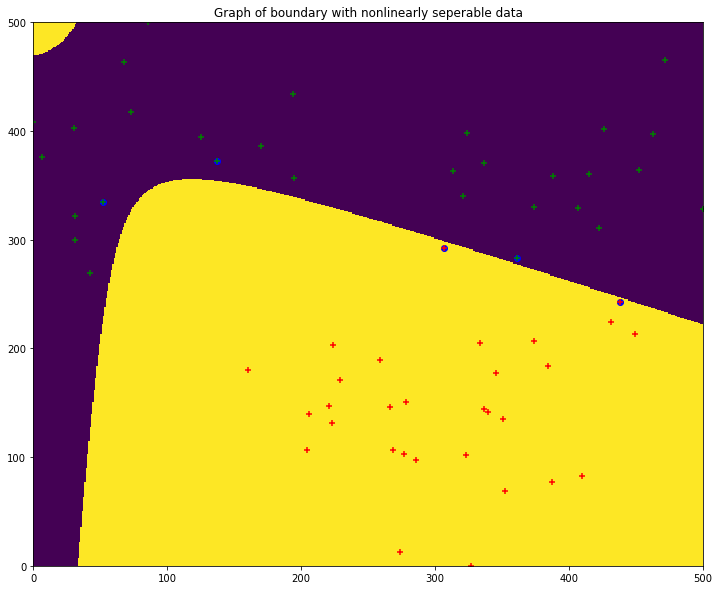

In [19]:
class11 = []
class21 = []

for i in range(y_nonlin.shape[0]):
    if y_nonlin[i] == 1:
        class11.append(x_nonlin[i])
    elif y_nonlin[i] == -1:
        class21.append(x_nonlin[i])

class11 = np.array(class11)
class21 = np.array(class21)

fig1, ax1 = plt.subplots(figsize=[12,10])
ax1.pcolormesh(y_list1.T)
ax1.set_title('Graph of boundary with nonlinearly seperable data')
ax1.scatter(scale11*(sv_x1[:,0] - np.min(x_nonlin[:,0])), scale21*(sv_x1[:,1] - np.min(x_nonlin[:,1])), color = 'b')
ax1.scatter(scale11*(class21[:,0] - np.min(x_nonlin[:,0])), scale21*(class21[:,1] - np.min(x_nonlin[:,1])), color = 'g', marker = '+')
ax1.scatter(scale11*(class11[:,0] - np.min(x_nonlin[:,0])), scale21*(class11[:,1] - np.min(x_nonlin[:,1])), color = 'r', marker = '+')